## Motivation

The production process of flat sheet steel is especially delicate. From heating and rolling, to drying and cutting, several machines touch flat steel by the time it’s ready to ship making it suspectible to different defects. 



## Dataset Information 

file description
* train_images/ - folder of training images
* test_images/ - folder of test images (you are segmenting and classifying these images)
* train.csv - training annotations which provide segments for defects (ClassId = [1, 2, 3, 4])
* sample_submission.csv - a sample submission file in the correct format; note, each ImageId 4 rows, one for each of the 4 defect classes

 
## Project Overview
The objective of this project is to predict the location and type of defects found in steel manufacturing using the images provided.


## References


**Please upvote if you like my work.**

# **1. Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random as rand
from random import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import warnings
!pip install -U segmentation-models
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from PIL import Image
warnings.filterwarnings("ignore")



2021-10-24 23:05:07.197950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


     |████████████████████████████████| 50 kB 1.4 MB/s 
Segmentation Models: using `tf.keras` framework.


# **2. Data Preprocessing**

In [2]:
#Loading the csv file
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


**Comment**:
The above dataframe contains the data for defective images in the training set where:
* ImageId represents the image file name
* ClassId represents the defect labels out of [1 2 3 4]
* EncodedPixels column contains RLE encoded mask for the particular defect type or is empty, when the defect is not found. <br>
Note: EncodedPixels column is the encoding of the segmentation using RLE or "Run Length Encoding". This is a lossless data compression technique which stores sequences that contain many consecutive data element as a single value followed by the occurence count.
<br>


Let us add non-defective images to this dataframe and a binary label to identify defective and non-defective images.

In [3]:
#find the number of images in the train set and test set
train_path = '../input/severstal-steel-defect-detection/train_images/'
test_path = '../input/severstal-steel-defect-detection/test_images/'
train_files = sorted(glob(train_path + "*.jpg"))
test_files  = sorted(glob(test_path + "*.jpg"))
print("Number of images for training: {}".format(len(train_files)))
print("Number of images for testing: {}".format(len(test_files)))
#os.listdir

Number of images for training: 12568
Number of images for testing: 5506


In [4]:
# https://www.kaggle.com/lifa08/run-length-encode-and-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.pad(pixels,((1,1),))  #pad zeros , one in front one inback
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



def rle2maskResize(rle):
    '''
    Generates masks for each image taking RLE as input
    Converts run length encoding to an image of shape defined uniform throughout segmentation models: 256x800
    Takes EncodedPixels as input, converts into 256x1600 mask and returns a resized mask image of size 256x800
    '''
    if (pd.isnull(rle))|(rle==''): # If the EncodedPixels string is empty an empty mask is returned
        return np.zeros((256,800) ,dtype=np.uint8)

    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1 # The pixel array definition starts from 1 while array starts from 0
    lengths = array[1::2]  # The second element of EncodedPixels is the length denoting number of pixels in successive that are active (value = 1)
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1 # Making 
    
    return mask.reshape((height,width),order='F')[::,::2]
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])] #start of zeros and ones and corresponding length
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1   
    return img.reshape(shape).T     #arrange in the form of an image



def df_preprocessed(data,path): 
  """ Takes the dataframe as input and returns the processed dataframe with non-defective images and binary masks""" 
  data['sum_mask_pixels'] = data.apply(lambda x: rle2mask(x['EncodedPixels']).sum(),axis = 1)
  # count the image file names for the given directory
  image_file_list = []
  for image_file in os.listdir(path):
      if image_file not in data['ImageId'].values: #if its not in the original data
          image_file_list.append(image_file)
  # creating dictionary of non-defective images
  nd = {"ImageId":image_file_list,"ClassId":0,"EncodedPixels":0,"sum_mask_pixels":0}
  data_non_defective = pd.DataFrame(nd)
  #merge both data
  data = pd.concat([data,data_non_defective])
  data = data.sample(frac=1,random_state=42).reset_index(drop=True)
  data["binary_label"] = data["ClassId"].apply(lambda x: 0 if x == 0 else 1)
  return data

In [5]:
data = df_preprocessed(train_df,train_path)
data

,ImageId,ClassId,EncodedPixels,sum_mask_pixels,binary_label
0,e9b10d130.jpg,0,0,0,0
1,026105525.jpg,0,0,0,0
2,d5425f5f5.jpg,3,123137 16 123393 46 123649 76 123905 107 12416...,10989,1
3,1233290d1.jpg,0,0,0,0
4,b58132808.jpg,3,68 90 324 89 580 89 836 88 1092 87 1348 86 160...,90123,1
...,...,...,...,...,...
12992,c6458c18b.jpg,0,0,0,0
12993,bb352d01e.jpg,1,285040 7 285296 19 285551 27 285807 27 286063 ...,1823,1
12994,c293952c8.jpg,3,175062 43 175233 128 175404 213 175618 255 175...,12505,1
12995,1f4161475.jpg,1,70801 5 71057 13 71313 21 71569 29 71824 34 72...,4434,1


# **3. Exploratory Data Analysis**

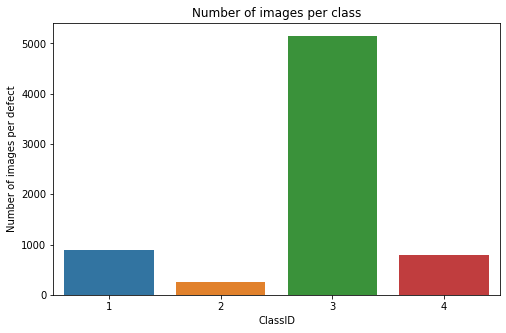

In [6]:
plt.figure(figsize=(8,5))
sns.countplot(data= train_df, x='ClassId')
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')
plt.show()


**Comment**:<br>
The dataset is not balanced. Some data augmentation techniques have to be performed to balance this data.

In [7]:
classid_count = train_df.ClassId.value_counts().sort_index(ascending = True)

perc_classid = classid_count/len(train_df)*100

# for i in range(len(classid_count)):
#     print('There are {} images of type {} defect i.e. {} %'.format(classid_count.iloc[i],i+1,
#                                                                    round(perc_classid.iloc[i],2)))


df = pd.concat([classid_count.rename('Count'),round(perc_classid,2).rename('Count_Percentage')],axis  = 1).reset_index().rename(columns = {'index':'ClassId'})
df

,ClassId,Count,Count_Percentage
0,1,897,12.64
1,2,247,3.48
2,3,5150,72.59
3,4,801,11.29


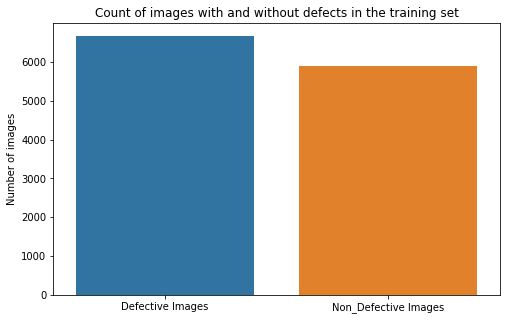

In [8]:
Non_defective_images = len(train_files) - len(train_df.ImageId.unique())
Defective_images  = len(train_df.ImageId.unique())
plt.figure(figsize=(8,5))
sns.barplot(x = ['Defective Images','Non_Defective Images'], y = [Defective_images,Non_defective_images])
plt.ylabel('Number of images')
plt.title('Count of images with and without defects in the training set')
plt.show()

In [9]:
binary_label_count = pd.Series([Defective_images,Non_defective_images])
perc_label_count = binary_label_count/len(train_files)*100
df = pd.DataFrame({'Count':binary_label_count,'Count_Percentage':round(perc_label_count,2)})
df = df.rename(index={0: 'non-defective',1:'defective'}).reset_index().rename(columns = {'index':'Image type'})
df

,Image type,Count,Count_Percentage
0,non-defective,6666,53.04
1,defective,5902,46.96


In [10]:
labels_per_image = train_df.groupby('ImageId')['EncodedPixels'].count()

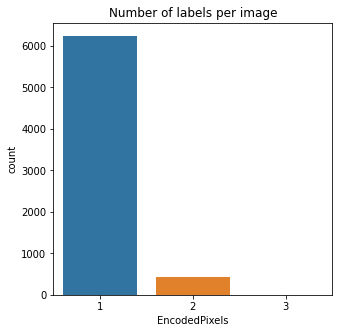

In [11]:
plt.figure(figsize=(5,5))
sns.countplot(labels_per_image)
plt.title("Number of labels per image")
plt.show()

In [12]:
label_count = labels_per_image.value_counts().sort_index(ascending = True)
perc_labels = label_count/len(labels_per_image)*100
# for i in range(len(label_count)):
#     print('There are {} images with {} labels i.e. {} %'.format(label_count.iloc[i],i+1,
#                                                                    round(perc_labels.iloc[i],2)))
df = pd.concat([label_count.rename('Count'),round(perc_labels,2).rename('Count_Percentage')],axis  = 1).reset_index().rename(columns = {'index':'No_of_defects'})
df

,No_of_defects,Count,Count_Percentage
0,1,6239,93.59
1,2,425,6.38
2,3,2,0.03


In [13]:
class_ids = [1,2,3,4]
pixel_sum_per_class = [train_df[(train_df['ClassId']==class_id)&(train_df['sum_mask_pixels']!=0.0)]['sum_mask_pixels'].sum() for class_id in class_ids]
perc_pixel_sum_per_class = np.round(pixel_sum_per_class/sum(pixel_sum_per_class)*100,2)
pixel_avg_per_class = [train_df[(train_df['ClassId']==class_id)&(train_df['sum_mask_pixels']!=0.0)]['sum_mask_pixels'].mean() for class_id in class_ids]
perc_pixel_avg_per_class = np.round(np.array(pixel_avg_per_class)/sum(pixel_avg_per_class)*100,2)
df_pixel =  pd.DataFrame({'ClassId':[1,2,3,4],'Sum_of_pixels':pixel_sum_per_class,'Percentage_sum': perc_pixel_sum_per_class
                         ,'Avg_of_pixels':pixel_avg_per_class,'Percentage_avg': perc_pixel_avg_per_class})
df_pixel

,ClassId,Sum_of_pixels,Percentage_sum,Avg_of_pixels,Percentage_avg
0,1,3912129,2.39,4361.347826,6.45
1,2,834471,0.51,3378.425101,5.00
2,3,131306899,80.27,25496.485243,37.71
3,4,27533572,16.83,34373.997503,50.84


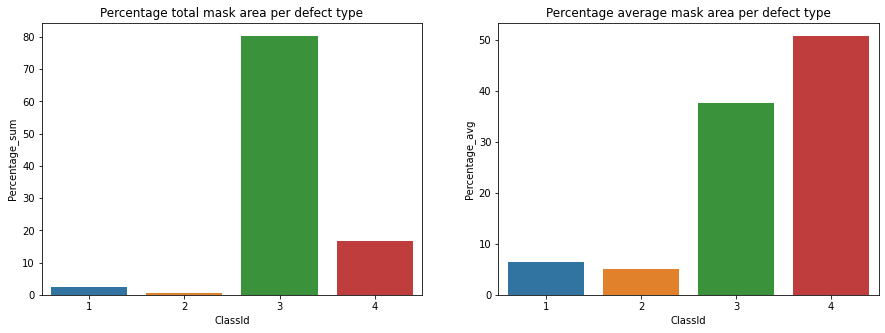

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.barplot(data = df_pixel,x = 'ClassId',y = 'Percentage_sum', ax = axs[0])
axs[0].set_title("Percentage total mask area per defect type")
sns.barplot(data = df_pixel,x = 'ClassId',y = 'Percentage_avg', ax = axs[1])
axs[1].set_title("Percentage average mask area per defect type")
plt.show()

**Comment**:<br>
Total defect size for type 3 is the highest however on average we see that the defect size for class 4 is the highest.

### Visualizing the images for different class

In [15]:
train_img_set = set(os.listdir(train_path))
defect_img_set = set(train_df['ImageId'].values)
non_defect_img_set = train_img_set - defect_img_set

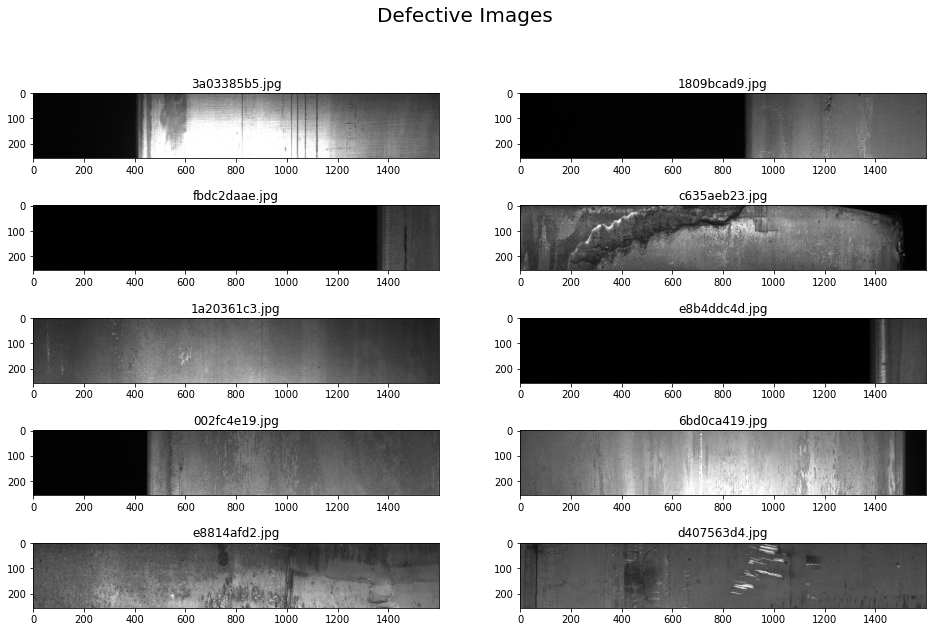

In [16]:
#displaying images from defective image set
fig, axs = plt.subplots(5, 2, figsize=(16,10))
fig.suptitle('Defective Images', fontsize=20)
x,y = 0,0
for i, img_id in enumerate(rand.sample(defect_img_set, 10)):
    img_obj = cv2.imread(train_path + img_id)
    axs[i//2,i%2].imshow(img_obj)
    axs[i//2,i%2].set_title(img_id)
plt.show()

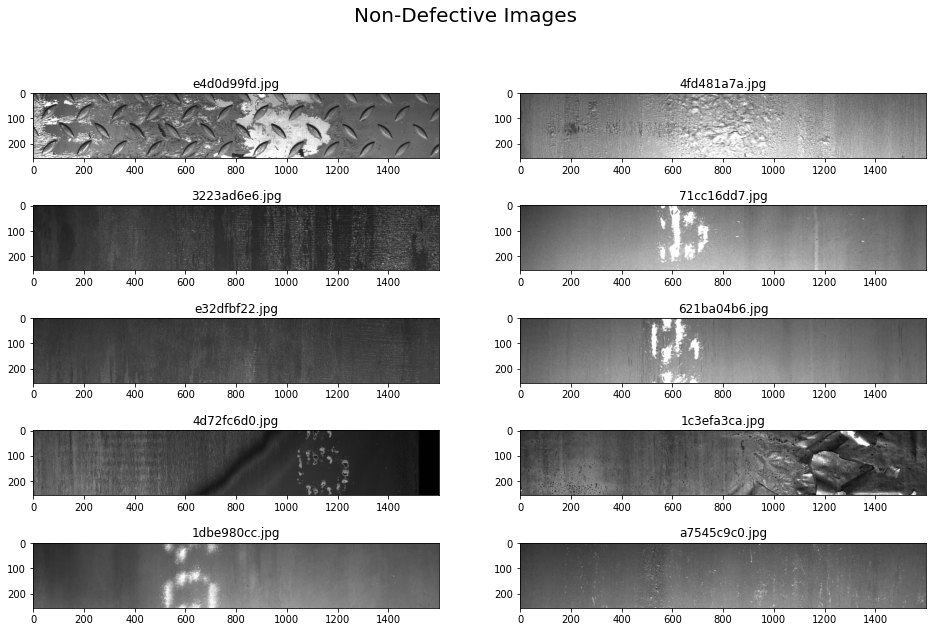

In [17]:
#displaying images from non-defective image set
fig, axs = plt.subplots(5, 2, figsize=(16,10))
fig.suptitle('Non-Defective Images', fontsize=20)
x,y = 0,0
for i, img_id in enumerate(rand.sample(non_defect_img_set, 10)):
    img_obj = cv2.imread(train_path + img_id)
    axs[i//2,i%2].imshow(img_obj)
    axs[i//2,i%2].set_title(img_id)
plt.show()

**Comment**:<br>
It looks like even some of the images from Non-defective set(ImgaeIds that are not in train.csv) are defective. May be these defect classes are not in [1, 2, 3, 4]

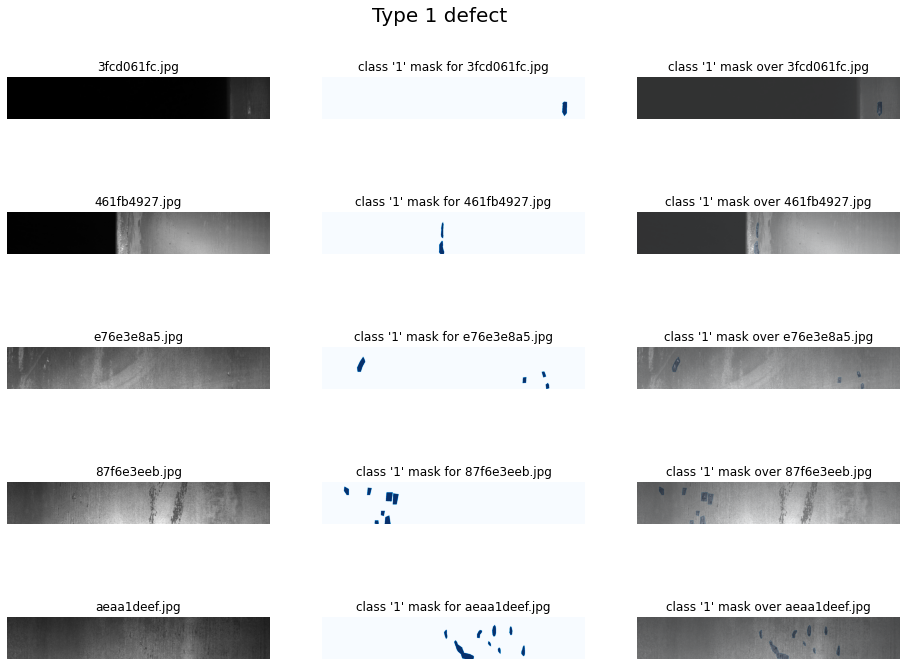

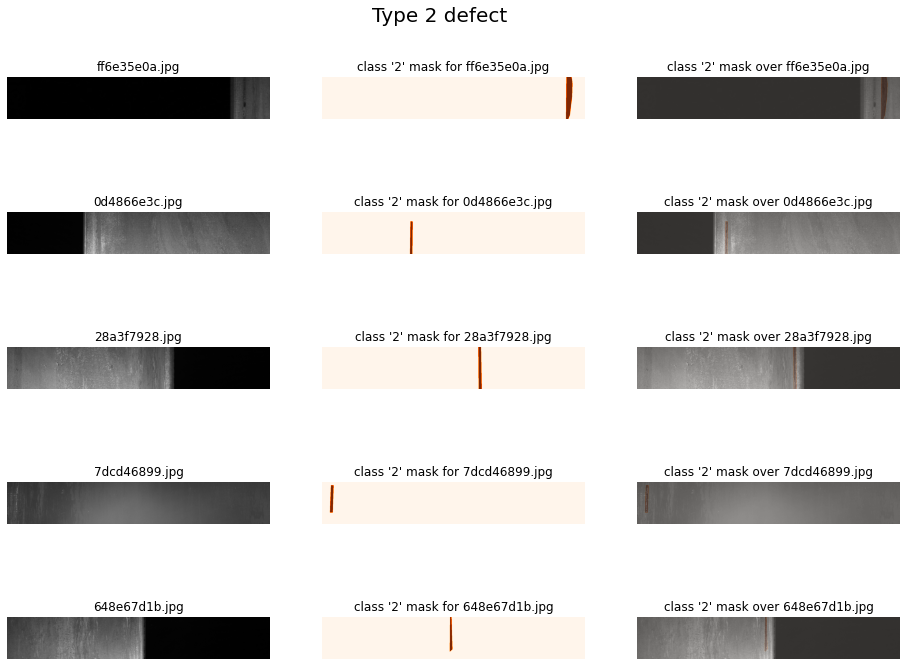

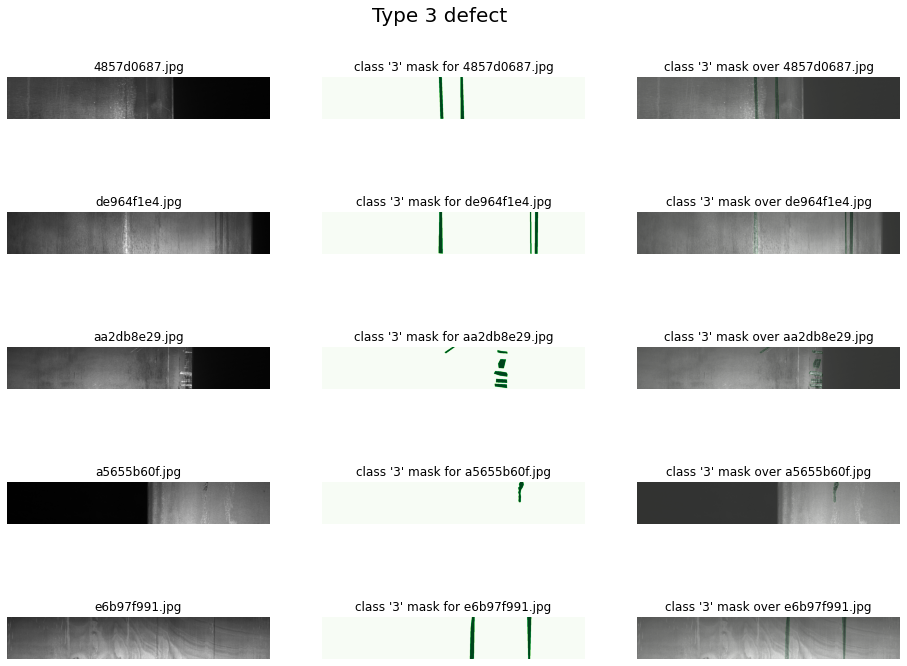

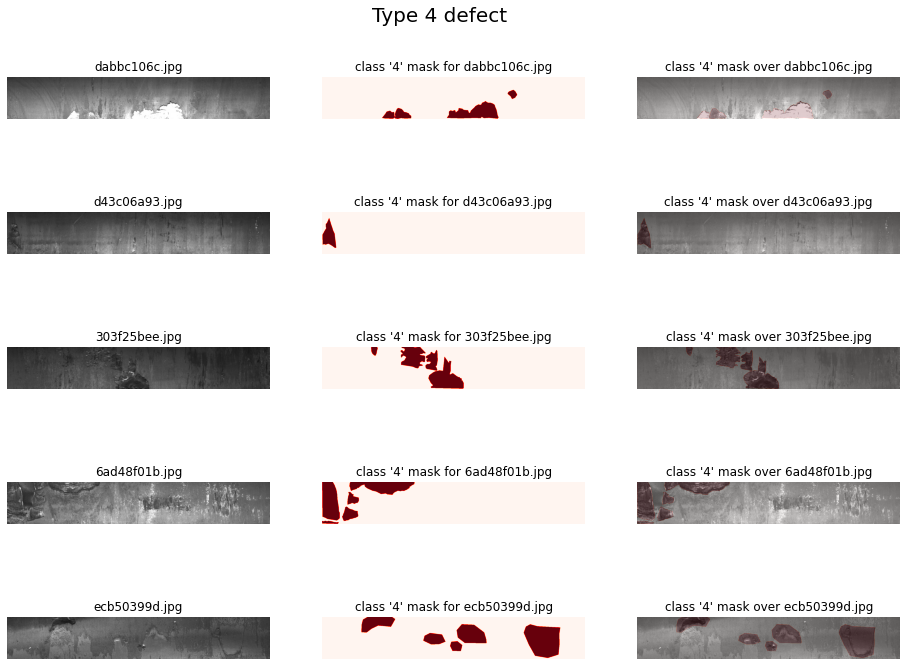

In [18]:

#Visualizing defective images for each ClassIds 
cmaps = ['Blues','Oranges','Greens','Reds']
for ClassId in [1,2,3,4]:
    class_df = data[data['ClassId'] == ClassId]
    fig, axs = plt.subplots(5, 3, figsize=(16,12))
    fig.suptitle("Type {} defect".format(ClassId), fontsize=20, y = 0.92)
    x,y = 0,0
    for i, img_id in enumerate(rand.sample(set(class_df['ImageId'].values), 5)):
        #plot the defective image
        img_obj = cv2.imread(train_path + img_id)
        axs[i,0].imshow(img_obj)
        axs[i,0].set_title(img_id)
        axs[i,0].axis('off')
        rle = class_df[class_df['ImageId'] == img_id]['EncodedPixels'].iloc[0]
        #plot the mask
        mask = rle2mask(rle)
        axs[i,1].imshow(mask,cmap = cmaps[ClassId-1])
        axs[i,1].set_title("class '{}' mask for ".format(ClassId) + img_id)
        axs[i,1].axis('off')
        #plot image with mask
        #img_obj[mask == 1,1] = 10 option 1 to show the mask
        axs[i,2].imshow(img_obj)
        axs[i,2].imshow(mask, alpha = 0.2, cmap = cmaps[ClassId-1])
        axs[i,2].set_title("class '{}' mask over ".format(ClassId) + img_id)
        axs[i,2].axis('off')
    plt.show()
    print('='*125)


In [19]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

**Comment**:
We can see several similarities in the mask area for these four classes. Defect type 1 has multiple smaller sized defective regions while defect type 4 has multiple larger sized defective regions. Defect type 3 also has images containing multiple larger sized defects. Several images in type 2 and type 3 defects share some regional characteristics.

### Understanding area under defect for different classes

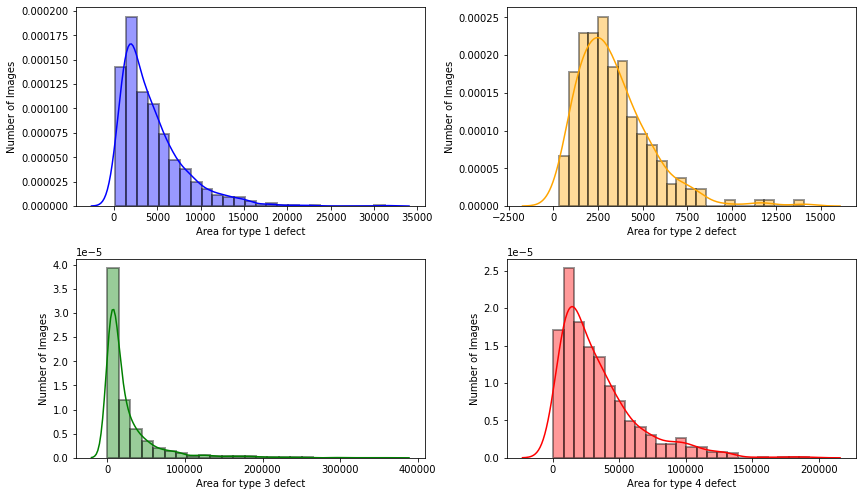

******************************************************************************************************************************************************


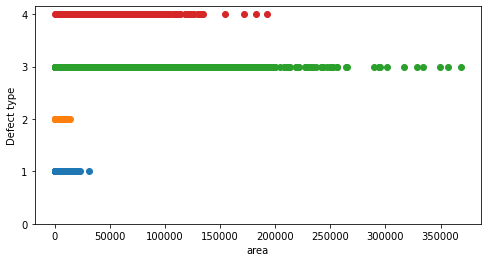

******************************************************************************************************************************************************


,count,mean,std,min,25%,50%,75%,max
Defect_1,897.0,4361.347826,3591.053407,163.0,1762.00,3326.0,5795.0,31303.0
Defect_2,247.0,3378.425101,2049.382114,316.0,1947.50,2944.0,4337.5,14023.0
Defect_3,5150.0,25496.485243,37945.334103,115.0,5054.25,11953.5,29029.5,368240.0
Defect_4,801.0,34373.997503,29590.265099,491.0,13114.00,25357.0,45221.0,192780.0


In [20]:

fig, axs = plt.subplots(2, 2,figsize=(12,7))
color = ['blue','orange','green','red']
data.loc[:,'Area'] = 0
for i in range(4):
    tmp = data['EncodedPixels'][data['ClassId']==i+1].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
    data['Area'][data['ClassId']==i+1] = tmp
    sns.distplot(a = tmp.values, ax = axs[i//2,i%2],bins = 25,color = color[i],kde = True,hist_kws=dict(edgecolor="k", linewidth=2))
    axs[i//2,i%2].set_xlabel('Area for type {} defect'.format(i+1))
    axs[i//2,i%2].set_ylabel('Number of Images')
plt.tight_layout()
plt.show()
print('*'*150)

tmp_list = []
plt.figure(figsize=(8,4))
for i in [1,2,3,4]:
    tmp = data['EncodedPixels'][data['ClassId']==i].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]]))
    tmp_list.append(tmp.describe())
    plt.plot(tmp,np.zeros_like(tmp)+i,'o')
plt.xlabel('area')
plt.yticks(ticks = [ 0 , 1 , 2 ,3 , 4])
plt.ylabel('Defect type')
plt.show()
print('*'*150)

area_df = pd.DataFrame(tmp_list)
area_df.index=['Defect_1','Defect_2','Defect_3','Defect_4']
area_df

**Comment**:<br>
We can see significant overlap in the area range. minimum areas for different defect types seem closer to eeach other while maximum area is largely different. We will use minimum and maximum values of areas in training images to threshold test image defect predictions.

In [21]:

# removing areas below 2 percentile and above 98 percentile to threshold area of predicted masks
tmp = []
for i in [1,2,3,4]:
    tmp_1 = data['EncodedPixels'][data['ClassId']==i].apply(lambda s: sum([int(k) for k in s.split(' ')[1::2]])).sort_values().reset_index().drop('index',axis=1)
    tmp.append([tmp_1.iloc[int(0.02*len(tmp_1))].values[0],tmp_1.iloc[-int(0.02*len(tmp_1))].values[0]])
print('Limiting area to above 2 percentile and below 98 percentile values for different classes: \n',tmp)

Limiting area to above 2 percentile and below 98 percentile values for different classes: 
 [[545, 14847], [673, 9641], [1146, 160856], [2959, 120287]]


In [22]:
area_threshold = pd.DataFrame(tmp,columns=['min','max'], index=['Class 1','Class 2','Class 3','Class 4'])
area_threshold
#this has to be done after splitting the data into train and test set. (cell 12 in rookfalcon)

,min,max
Class 1,545,14847
Class 2,673,9641
Class 3,1146,160856
Class 4,2959,120287


# **4. Modelling**

### Defining evaluation metrics

In [23]:
def dice_coef(y_true, y_pred, smooth= K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Custom metrics, https://stackoverflow.com/questions/59196793/why-are-my-metrics-of-my-cnn-not-changing-with-each-epoch
# For clasification
def recall_m(y_true, y_pred):
    '''
    This function returns recall_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns recall score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
    recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
    return recall

def precision_m(y_true, y_pred):
    '''
    This function returns precison_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns prediction score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
    precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
    return precision
    
def f1_score_m(y_true, y_pred):
    '''
    This function returns f1_score between y_true and y_pred
    This 
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns f1 score of the batch
    '''
    precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
    recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

dependencies = {
    'recall_m':recall_m,
    'precision_m':precision_m,
    'dice_coef':dice_coef,
    'f1_score_m':f1_score_m,
    'dice_loss':sm.losses.dice_loss
}

In [24]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(2,3,figsize = (20,15))
  ax[0,0].plot(epochRange,history.history['acc'],'b',label = 'Training Accuracy')
  ax[0,0].plot(epochRange,history.history['val_acc'],'r',label = 'Validation Accuracy')
  ax[0,0].set_title('Training and Validation accuracy')
  ax[0,0].set_xlabel('Epoch',fontsize = 15)
  ax[0,0].set_ylabel('Accuracy',fontsize = 15)
  ax[0,0].legend()
  ax[0,0].grid(color='gray', linestyle='--')
  ax[0,1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[0,1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[0,1].set_title('Training and Validation loss')
  ax[0,1].set_xlabel('Epoch',fontsize = 15)
  ax[0,1].set_ylabel('Loss',fontsize = 15)
  ax[0,1].legend()
  ax[0,1].grid(color='gray', linestyle='--')
  ax[0,2].plot(epochRange,history.history['precision_m'],'b',label = 'Training Precision')
  ax[0,2].plot(epochRange,history.history['val_precision_m'],'r',label = 'Validation Precision')
  ax[0,2].set_title('Training and Validation precision')
  ax[0,2].set_xlabel('Epoch',fontsize = 15)
  ax[0,2].set_ylabel('Precision',fontsize = 15)
  ax[0,2].legend()
  ax[0,2].grid(color='gray', linestyle='--')
  ax[1,0].plot(epochRange,history.history['recall_m'],'b',label = 'Training Recall')
  ax[1,0].plot(epochRange,history.history['val_recall_m'],'r',label = 'Validation Recall')
  ax[1,0].set_title('Training and Validation recall')
  ax[1,0].set_xlabel('Epoch',fontsize = 15)
  ax[1,0].set_ylabel('Recall',fontsize = 15)
  ax[1,0].legend()
  ax[1,0].grid(color='gray', linestyle='--')
  ax[1,1].set_visible(False)
  ax[1,2].plot(epochRange,history.history['f1_score_m'],'b',label = 'Training F1 score')
  ax[1,2].plot(epochRange,history.history['val_f1_score_m'],'r',label = 'Validation F1 score')
  ax[1,2].set_title('Training and Validation F1 score')
  ax[1,2].set_xlabel('Epoch',fontsize = 15)
  ax[1,2].set_ylabel('F1 score',fontsize = 15)
  ax[1,2].legend()
  ax[1,2].grid(color='gray', linestyle='--')
  plt.show()

## **1. Binary Classification to classify defective and non defective images**

### Step I: Data Preparation

In [25]:
# Getting images and corresponding binary labels
data_b = data[['ImageId','binary_label']]
data_b = data_b.drop_duplicates().reset_index(drop = True) #removing duplicates caused due to multilabel labels for same image
data_b.head()

,ImageId,binary_label
0,e9b10d130.jpg,0
1,026105525.jpg,0
2,d5425f5f5.jpg,1
3,1233290d1.jpg,0
4,b58132808.jpg,1


In [26]:
#Splitting data into train set and validation set
train_b, val_b = train_test_split(data_b, random_state=42, test_size=0.2)
print('train_b shape:',train_b.shape,'val_b shape:',val_b.shape)

train_b shape: (10054, 2) val_b shape: (2514, 2)


In [27]:
#generate augmented data
train_datagen_b=ImageDataGenerator(rescale=1./255.,
                           shear_range=0.2,
                           zoom_range=0.05,
                           brightness_range=[0.8,1.0],
                           rotation_range=5,
                           horizontal_flip=True,
                           vertical_flip=True
                           )
#test_datagen_b=ImageDataGenerator(rescale=1./255.)

train_gen=train_datagen_b.flow_from_dataframe(
dataframe=train_b.astype(str),
directory=train_path,
x_col="ImageId",
y_col="binary_label",
batch_size=16,
seed=42,
class_mode="binary",
target_size=(256,256))

val_gen=train_datagen_b.flow_from_dataframe(
dataframe=val_b.astype(str),
directory=train_path,
x_col="ImageId",
y_col="binary_label",
batch_size=16,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(256,512))

Found 10054 validated image filenames belonging to 2 classes.
Found 2514 validated image filenames belonging to 2 classes.


### Step 2: Defining the model architecture

In [28]:
#https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41

In [29]:

def binary_classification_model(input_shape):
#https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202
    base_model = Xception(input_shape= input_shape, include_top=False)
#     base_model.trainable=False #freezing the layer

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(1,activation='sigmoid')(x) #final layer binary classifier

    model_binary=Model(inputs=base_model.input,outputs=out) 
    #model_binary.summary()
    return model_binary

In [30]:
binary_model = binary_classification_model(input_shape=(256,512,3))

2021-10-24 23:06:21.670943: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-24 23:06:21.674482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-24 23:06:21.713342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 23:06:21.714010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-24 23:06:21.714078: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-24 23:06:21.742019: I tensorflow/stream_executor/platform/def

83689472/83683744 [==============================] - 2s 0us/step


### Step 3: Training the model

In [31]:
'''epochnum = 10
#compile the model
binary_model.compile(optimizer='adam', 
                     loss='binary_crossentropy',
                     metrics=['acc',f1_score_m,precision_m,recall_m])



#model_checkpoint
mc = ModelCheckpoint('severstal_binary_1.h5', monitor='val_f1_score_m', mode='max', verbose=1, save_best_only=True)

#train the model
r = binary_model.fit_generator(train_gen, 
                                validation_data = val_gen, 
                                epochs = epochnum, verbose=1,callbacks = [mc])
n_epochs = len(r.history['loss'])
                                '''

"epochnum = 10\n#compile the model\nbinary_model.compile(optimizer='adam', \n                     loss='binary_crossentropy',\n                     metrics=['acc',f1_score_m,precision_m,recall_m])\n\n\n\n#model_checkpoint\nmc = ModelCheckpoint('severstal_binary_1.h5', monitor='val_f1_score_m', mode='max', verbose=1, save_best_only=True)\n\n#train the model\nr = binary_model.fit_generator(train_gen, \n                                validation_data = val_gen, \n                                epochs = epochnum, verbose=1,callbacks = [mc])\nn_epochs = len(r.history['loss'])\n                                "

In [32]:
#plot the learning curve
#plotLearningCurve(r,n_epochs)

### Step 4: Evaluating the model

In [33]:
#load the best model
binary_model = load_model('../input/classification-models-for-steel-defect/severstal_binary.h5', custom_objects=dependencies)

In [34]:
binary_model.compile(loss=binary_model.loss, optimizer=binary_model.optimizer, metrics=['acc',f1_score_m,precision_m,recall_m])

In [35]:
print("Train score:", binary_model.evaluate(train_gen,verbose = 2))
print("Validation score:", binary_model.evaluate(val_gen, verbose = 2))

2021-10-24 23:06:35.749107: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-24 23:06:35.753286: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz
2021-10-24 23:06:37.380652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-24 23:06:38.186151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-24 23:06:38.226505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


629/629 - 280s - loss: 0.1851 - acc: 0.9286 - f1_score_m: 0.9285 - precision_m: 0.9291 - recall_m: 0.9376
Train score: [0.18507233262062073, 0.9285856485366821, 0.9285385012626648, 0.9290720224380493, 0.9375608563423157]
158/158 - 106s - loss: 0.2470 - acc: 0.9021 - f1_score_m: 0.9015 - precision_m: 0.8720 - recall_m: 0.9422
Validation score: [0.24696111679077148, 0.9021479487419128, 0.9014626741409302, 0.8719809055328369, 0.9422009587287903]


## **2. Multilabel Classification to classify different types of defects**

### Step 1: Data Preparation

In [36]:
# Getting images and creating their corresponding one hot encoded labels
columns = ['c1','c2','c3','c4']
data_m = data[['ImageId','ClassId']][data['binary_label']==1]
one_hot = pd.get_dummies(data_m['ClassId'])
one_hot.columns = columns
data_m= pd.concat([data_m[['ImageId']],one_hot],axis = 1).groupby('ImageId').sum().reset_index()

In [37]:
#Splitting data into train set and validation set
train_m, val_m = train_test_split( data_m, random_state=42,test_size=0.2)
print('train_data shape:',train_m.shape,'val_data:',val_m.shape)

train_data shape: (5332, 5) val_data: (1334, 5)


In [38]:
#generate augmented data
train_datagen_m=ImageDataGenerator(rescale=1./255.,
                           shear_range=0.2,
                           zoom_range=0.05,
                           brightness_range=[0.8,1.0],
                           rotation_range=5,
                           horizontal_flip=True,
                           vertical_flip=True
                           )
test_datagen_m=ImageDataGenerator(rescale=1./255.)

train_gen=train_datagen_m.flow_from_dataframe(
dataframe=train_m,
directory=train_path,
x_col="ImageId",
y_col=columns,
batch_size=16,
seed=42,
class_mode="raw",
target_size=(256,512))

val_gen=train_datagen_m.flow_from_dataframe(
dataframe=val_m,
directory=train_path,
x_col="ImageId",
y_col=columns,
batch_size=16,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(256,512))

Found 5332 validated image filenames.
Found 1334 validated image filenames.


### Step 2: Defining the model architecture

In [39]:
def multilabel_classification_model(input_shape):
#https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202
    base_model = Xception(input_shape= input_shape, include_top=False)
#     base_model.trainable=False #freezing the layer


    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='sigmoid')(x)

    model_multi=Model(inputs=base_model.input,outputs=out) 
    #model_multi.summary()
    return model_multi

In [40]:
multilabel_model = multilabel_classification_model(input_shape=(256,512,3))

### Step 3: Training the model

In [41]:
'''epochnum = 20
#compile the model
multilabel_model.compile(optimizer='adam', 
                     loss='binary_crossentropy',
                     metrics=['acc',f1_score_m,precision_m,recall_m])



#model_checkpoint
mc = ModelCheckpoint('severstal_multi_1.h5', monitor='val_f1_score_m', mode='max', verbose=1, save_best_only=True)

#train the model
r = multilabel_model.fit_generator(train_gen, 
                                validation_data = val_gen, 
                                epochs = epochnum, verbose=1,callbacks = [mc])'''

"epochnum = 20\n#compile the model\nmultilabel_model.compile(optimizer='adam', \n                     loss='binary_crossentropy',\n                     metrics=['acc',f1_score_m,precision_m,recall_m])\n\n\n\n#model_checkpoint\nmc = ModelCheckpoint('severstal_multi_1.h5', monitor='val_f1_score_m', mode='max', verbose=1, save_best_only=True)\n\n#train the model\nr = multilabel_model.fit_generator(train_gen, \n                                validation_data = val_gen, \n                                epochs = epochnum, verbose=1,callbacks = [mc])"

In [42]:
#plot the learning curve
#plotLearningCurve(r,n_epochs)

### Step 4: Evaluating the model

In [43]:
#load the best model
multi_model = load_model('../input/classification-models-for-steel-defect/severstal_multi.h5', custom_objects=dependencies)

In [44]:
multi_model.compile(loss=binary_model.loss, optimizer=multi_model.optimizer, metrics=['acc',f1_score_m,precision_m,recall_m])

In [45]:
print("Train score:", multi_model.evaluate(train_gen,verbose = 2))
print("Validation score:", multi_model.evaluate(val_gen, verbose = 2))

334/334 - 196s - loss: 0.0685 - acc: 0.9291 - f1_score_m: 0.9505 - precision_m: 0.9565 - recall_m: 0.9463
Train score: [0.06847015768289566, 0.9291072487831116, 0.9504890441894531, 0.9565145373344421, 0.9462770223617554]
84/84 - 48s - loss: 0.0978 - acc: 0.9123 - f1_score_m: 0.9332 - precision_m: 0.9400 - recall_m: 0.9283
Validation score: [0.097836934030056, 0.9122938513755798, 0.9332164525985718, 0.9400421380996704, 0.928320586681366]


## **3. Segmentation of defects**

We will build four segmentation models to train four defect-classes separately, so that we can pass each defective image to respective segmentation model to predict the location of the defect area.

### Step 1: Data Preparation

In [46]:
columns = ['c1','c2','c3','c4']
data_seg = data[['ImageId','ClassId','EncodedPixels']][data['binary_label']==1]
one_hot = pd.get_dummies(data_seg['ClassId'])
one_hot.columns = columns
data_seg= pd.concat([data_seg[['ImageId','EncodedPixels']],one_hot],axis = 1).reset_index(drop = True)
data_seg.head()

,ImageId,EncodedPixels,c1,c2,c3,c4
0,d5425f5f5.jpg,123137 16 123393 46 123649 76 123905 107 12416...,0,0,1,0
1,b58132808.jpg,68 90 324 89 580 89 836 88 1092 87 1348 86 160...,0,0,1,0
2,3e2c33124.jpg,16114 15 16353 32 16603 38 16856 41 17112 41 1...,0,0,1,0
3,8f81e6d35.jpg,255471 18 255693 52 255915 86 256136 121 25635...,0,1,0,0
4,7cfcbdc4a.jpg,18390 43 18561 128 18733 212 18946 255 19202 2...,0,0,1,0


In [47]:
data_1 = data_seg[data_seg['c1']==1][['ImageId','EncodedPixels']]
data_2 = data_seg[data_seg['c2']==1][['ImageId','EncodedPixels']]
data_3 = data_seg[data_seg['c3']==1][['ImageId','EncodedPixels']]
data_4 = data_seg[data_seg['c4']==1][['ImageId','EncodedPixels']]

#Splitting data into train set and validation set
train_1, val_1 = train_test_split( data_1, random_state=42,test_size=0.2)
train_2, val_2 = train_test_split( data_2, random_state=42,test_size=0.2)
train_3, val_3 = train_test_split( data_3, random_state=42,test_size=0.2)
train_4, val_4 = train_test_split( data_4, random_state=42,test_size=0.2)
print('-'*50)
print("train_1 shape:",train_1.shape,"val_1 shape:",val_1.shape)
print("train_2 shape:",train_2.shape,"val_2 shape:",val_2.shape)
print("train_3 shape:",train_3.shape,"val_3 shape:",val_3.shape)
print("train_4 shape:",train_4.shape,"val_4 shape:",val_4.shape)


--------------------------------------------------
train_1 shape: (717, 2) val_1 shape: (180, 2)
train_2 shape: (197, 2) val_2 shape: (50, 2)
train_3 shape: (4120, 2) val_3 shape: (1030, 2)
train_4 shape: (640, 2) val_4 shape: (161, 2)


In [48]:
 # https://www.kaggle.com/cdeotte/keras-unet-with-eda
# https://stackoverflow.com/questions/52754492/write-custom-data-generator-for-keras
# DataGenerator custom built for training segmentation models with random image augmentations
# 
class train_DataGen(keras.utils.Sequence): # with augmentation for training
    '''
    The DataGenerator takes a batch of ImageIds of batch size 8 and returns Image array to the model with its mask.
    With the help of ImageIds the DataGenerator locates the Image file in the path, the image is read and resized from
    256 x 1600 to 256x800.
    A set of random numbers are generated to generate random Image Augmentations.
    Shuffling is enabled during training to include variations in the sequence of images processed at each epoch.
    '''
    def __init__(self, df, batch_size = 8,  shuffle=True, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '../input/severstal-steel-defect-detection/train_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,256,800,3),dtype=np.float32)
        X1 = np.empty((self.batch_size,256,800,3),dtype=np.float32)

        y = np.empty((self.batch_size,256,800,1),dtype=np.float32)
        y1 = np.empty((self.batch_size,256,800,1),dtype=np.float32)

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,256))           
            y[i,:,:,0] = rle2maskResize(self.df['EncodedPixels'].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)

        # generate some random image augmentations
        augment = random()
        if augment>0.35:
            in_gen1 = ImageDataGenerator()
            augment1 = random()
            augment2 = random()
            augment3 = random()
            augment4 = random()
            augment5 = random()
            augment6 = random()

            args = dict(tx = 0, ty = 0, zx = 1.0, zy= 1.0, flip_horizontal = False, flip_vertical = False)

            if augment1>0.5:
                args.update({'tx':50})

            if augment2>0.5:
                args.update({'ty':25})

            if augment3>0.5:
                args.update({'zx':0.9})

            if augment4>0.5:
                args.update({'zy':0.9})

            if augment5>0.5:
                args.update({'flip_horizontal' : True})

            if augment6>0.5:
                args.update({'flip_vertical' : True})

            for i,h in enumerate(X):
                X1[i] = in_gen1.apply_transform(h, transform_parameters = args)
            for i,g in enumerate(y):
                y1[i] = in_gen1.apply_transform(g, transform_parameters = args)
            return X1, y1
        else:
            return X, y

In [49]:
class test_DataGen(keras.utils.Sequence): # without augmentations for predictions
    '''
    The DataGenerator takes a batch of ImageIds of batch size 1 and returns Image array to the model with mask on validation
    dataset and without mask on test dataset.
    During Prediction and Evaluation stage Image augmentations are to not required. Thus this Train DataGenerator is modified 
    to create test Datagenerator
    With the help of ImageIds the DataGenerator locates the Image file in the path, the image is read and resized from
    256x1600 to 256x800.
    Shuffling is disabled during predictions to make sure each prediction belongs to its corresponding ImageId.
    '''
    def __init__(self, df, batch_size = 1, shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '../input/severstal-steel-defect-detection/train_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,256,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,256,800,1),dtype=np.float32)

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,256))      
            y[i,:,:,0] = rle2maskResize(self.df['EncodedPixels'].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

### Step 2: Model Architecture

In [50]:
# https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/preprocessing.py
# preprocesses image to input to the segmentation_model, generally image pixel value standardization
preprocess = get_preprocessing('efficientnetb1') 

# https://github.com/qubvel/segmentation_models
# segmentation using pretrained weights for faster convergence
segmentation_model = Unet('efficientnetb1', classes=1, activation='sigmoid', encoder_weights='imagenet') 
#model.summary()

27164672/27164032 [==============================] - 1s 0us/step


### Step 3: Segmentation Model for each defect

In [51]:
epochnum = 30

In [52]:
def segmentation_training(model,training_data,validation_data,epochnum,index):
    train_batches = train_DataGen(training_data,shuffle=True,preprocess=preprocess)    
    valid_batches = test_DataGen(validation_data,preprocess=preprocess)

    #model compilation
    model.compile(optimizer='adam', loss=sm.losses.dice_loss,metrics=[dice_coef])

    #model checkpoint
    mc = ModelCheckpoint(f'severstal_segmentation_{index}.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)

    #model train
    r = model.fit_generator(train_batches, validation_data = valid_batches, epochs = epochnum, verbose=1, callbacks = [mc])
    
    return r



In [53]:
#developing model for each defect
# r1 = segmentation_training(segmentation_model,train_1,val_1,epochnum,1)
# r2 = segmentation_training(segmentation_model,train_2,val_2,epochnum,2)
# r3 = segmentation_training(segmentation_model,train_3,val_3,epochnum,3)
# r4 = segmentation_training(segmentation_model,train_4,val_4,epochnum,4)

In [54]:
#loading best model for each defect
r1 = load_model('../input/segmentationmodelsforsteeldefect/severstal_segmentation_1.h5', custom_objects=dependencies)
r2 = load_model('../input/segmentationmodelsforsteeldefect/severstal_segmentation_2.h5', custom_objects=dependencies)
r3 = load_model('../input/segmentationmodelsforsteeldefect/severstal_segmentation_3.h5', custom_objects=dependencies)
r4 = load_model('../input/segmentationmodelsforsteeldefect/severstal_segmentation_4.h5', custom_objects=dependencies)

In [55]:
def plotLearningCurve_1(history,epochs):
  epochRange = range(1,epochs+1)
  plot(epochRange,history.history['dice_coeff'],'b',label = 'Training Dice Coefficient')
  plot(epochRange,history.history['val_dice_coeff'],'r',label = 'Validation Dice Coefficient')
  title('Training and Validation Dice Coefficients')
  plt.xlabel('Epoch',fontsize = 15)
  plt.ylabel('Accuracy',fontsize = 15)
  plt.legend()
  plt.grid(color='gray', linestyle='--')
  plt.show()

### Step 4: Segmentation Model evaluation

In [56]:
train_list = [train_1,train_2,train_3,train_4]
val_list = [val_1,val_2,val_3,val_4]
model_list = [r1,r2,r3,r4]
for i in range(4):
    model_list[i].compile(optimizer='adam', loss=sm.losses.dice_loss,metrics=[dice_coef])
    print(f'Train set evaluation score for defect {i+1}:')
    train_evaluate = model_list[i].evaluate(test_DataGen(train_list[i],preprocess=preprocess),verbose=1)
    print(f'Validation set evaluation score for defect {i+1} :')
    validation_evaluate = model_list[i].evaluate(test_DataGen(val_list[i],preprocess=preprocess),verbose=1)
    
    
    

Train set evaluation score for defect 1:
717/717 [==============================] - 23s 28ms/step - loss: 0.2720 - dice_coef: 0.7280
Validation set evaluation score for defect 1 :
180/180 [==============================] - 5s 28ms/step - loss: 0.3454 - dice_coef: 0.6546
Train set evaluation score for defect 2:
197/197 [==============================] - 8s 26ms/step - loss: 0.2537 - dice_coef: 0.7463
Validation set evaluation score for defect 2 :
50/50 [==============================] - 1s 25ms/step - loss: 0.3061 - dice_coef: 0.6939
Train set evaluation score for defect 3:
4120/4120 [==============================] - 116s 27ms/step - loss: 0.2526 - dice_coef: 0.7474
Validation set evaluation score for defect 3 :
1030/1030 [==============================] - 28s 28ms/step - loss: 0.2849 - dice_coef: 0.7151
Train set evaluation score for defect 4:
640/640 [==============================] - 21s 28ms/step - loss: 0.2050 - dice_coef: 0.7950
Validation set evaluation score for defect 4 :
161/

5/5 [==============================] - 2s 41ms/step


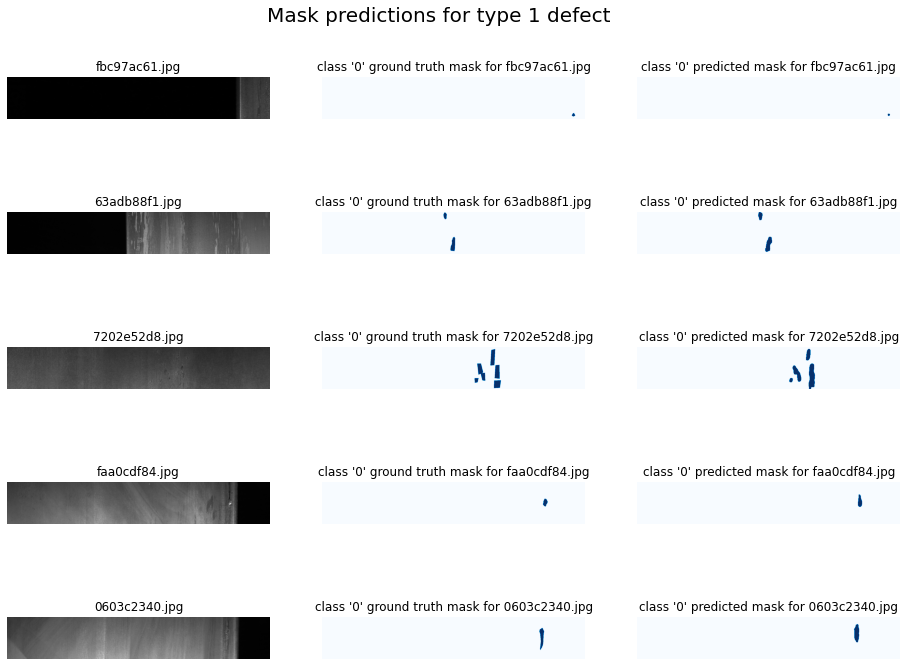

5/5 [==============================] - 2s 25ms/step


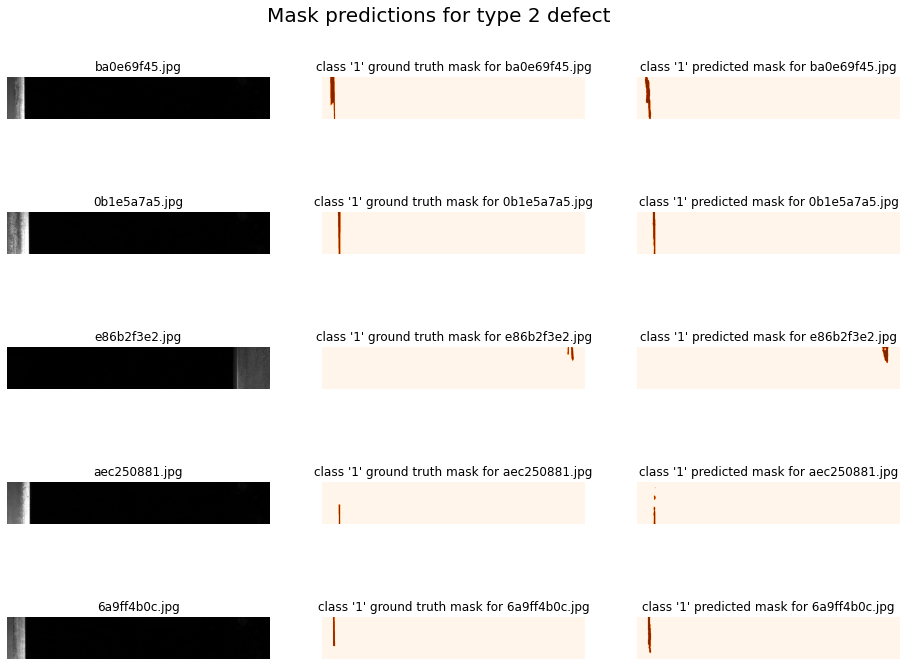

5/5 [==============================] - 2s 24ms/step


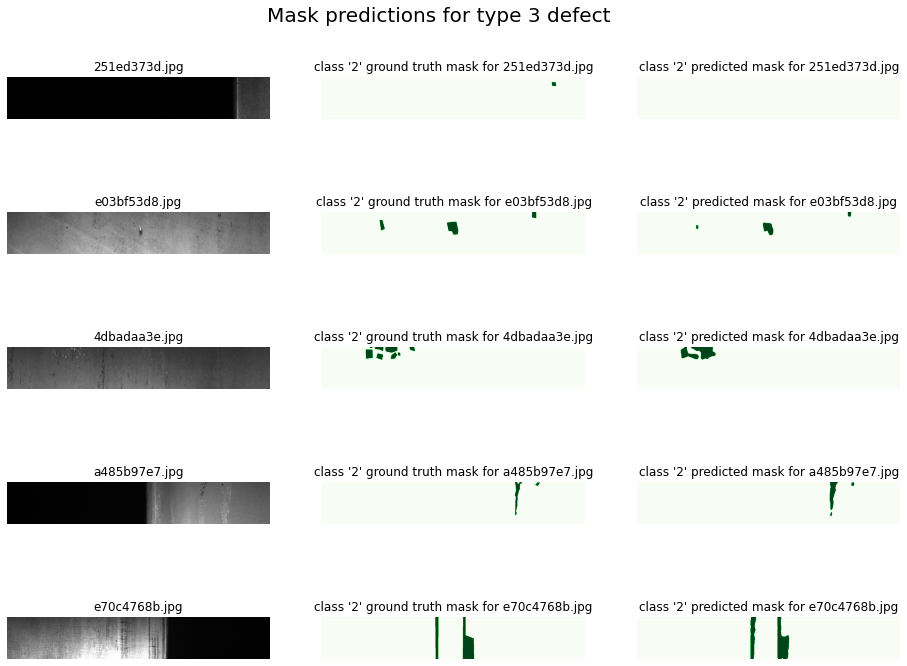

5/5 [==============================] - 2s 25ms/step


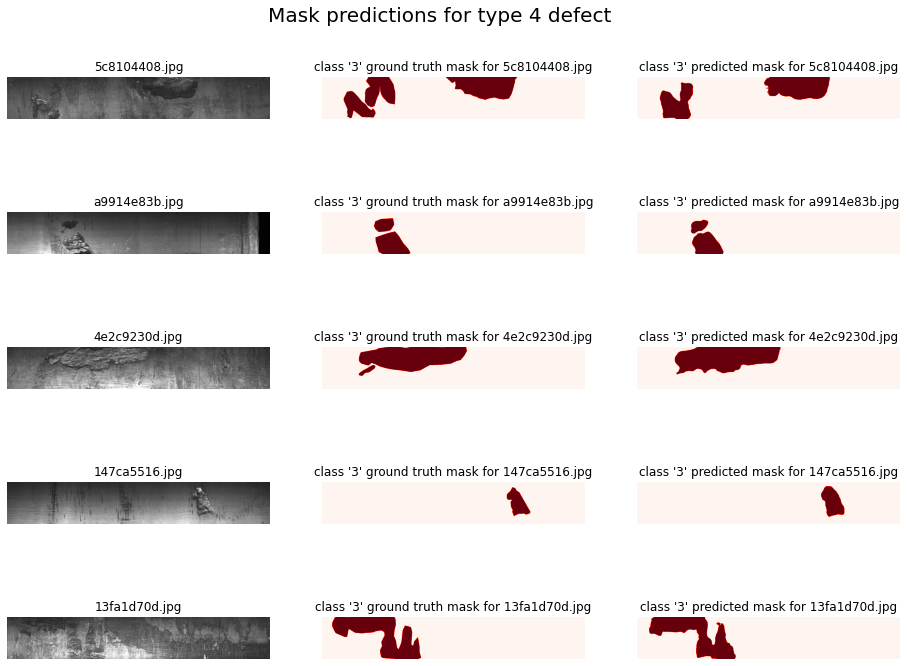

In [57]:
#prediction visualization

#Visualizing defective images for each ClassIds 
cmaps = ['Blues','Oranges','Greens','Reds']
for i in range(4):
    data_samples = train_list[i][20:25]
    train_preds = model_list[i].predict_generator(test_DataGen(data_samples,preprocess=preprocess),verbose=1)
    fig, axs = plt.subplots(5, 3, figsize=(16,12))
    fig.suptitle("Mask predictions for type {} defect".format(i+1), fontsize=20, y = 0.92)
    x,y = 0,0
    for j in range(5):
        #plot the defective image
        img_id = data_samples.ImageId.values[j]
        img_obj = cv2.imread(train_path + img_id ) #need to check
        axs[j,0].imshow(img_obj)
        axs[j,0].set_title(img_id)
        axs[j,0].axis('off')
        #plot the ground truth mask 
        rle = data_samples.EncodedPixels.values[j]
        mask = rle2mask(rle)
        axs[j,1].imshow(mask,cmap = cmaps[i])
        axs[j,1].set_title("class '{}' ground truth mask for ".format(i) + img_id)
        axs[j,1].axis('off')
        #plot the predicted mask
        pred_img = Image.fromarray(train_preds[j][:,:,0])
        axs[j,2].imshow(np.array(pred_img.resize((1600,256)))>0.5,cmap = cmaps[i])
        axs[j,2].set_title("class '{}' predicted mask for ".format(i) + img_id)
        axs[j,2].axis('off')
    plt.show()
    print('='*125)


### ..................To be continued: prediction on the test set, final results